# Is there any structure to the timestamp data?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.signal
import os
os.chdir('E:\\Google Drive\\kaggle\\03-facebook\\data')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0)

print('Reading train data')
df_train = pd.read_csv('train.csv')

Reading train data


In [3]:
print('\nSize of training data: ' + str(df_train.shape))
print('Columns:' + str(df_train.columns.values))
print('Number of places: ' + str(len(list(set(df_train['place_id'].values.tolist()))))) # set() for unique id


Size of training data: (29118021, 6)
Columns:['row_id' 'x' 'y' 'accuracy' 'time' 'place_id']
Number of places: 108390


## Estimate the autocorrelation of all of the timestamps to see if there are any repeating patterns

In [4]:
# Pull out timestamps
times = np.squeeze(df_train.as_matrix(columns=['time']))
n_events = times.size
n_samples = n_events
hist_range = (-100000.0, 100000.0)
n_bins = 100000 # One bin per 2.0 time units
n_loops = 100

In [5]:
# Estimate autocorrelations
# Randomly pull timestamps and subtract from each other. 
# Get histogram of these values to estimate autocorrelation
print('Estimating autocorrelation')
all_autocorrs_global = np.zeros((n_bins, n_loops))
for loop_n in range(n_loops):
  hist_vals, bin_edges = np.histogram(np.random.choice(times, size=n_samples, replace=True) - \
                                      np.random.choice(times, size=n_samples, replace=True), bins=n_bins, range=hist_range)
  all_autocorrs_global[:, loop_n] = hist_vals

Estimating autocorrelation


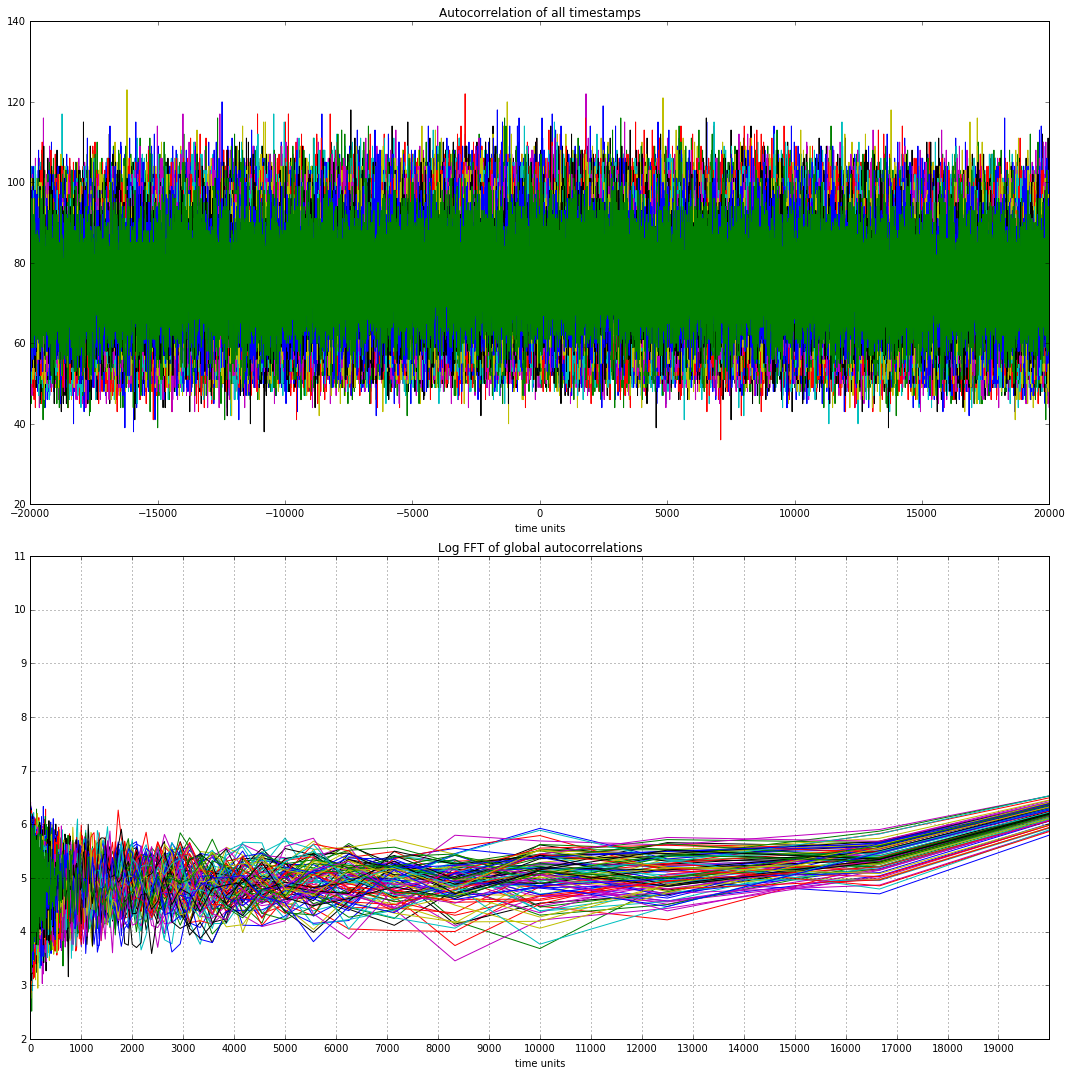

In [6]:
# Plot the autocorrelation and fft of autocorrelation
fig, axs = plt.subplots(2,1)

axs[0].plot(bin_edges[:-1], all_autocorrs_global)
axs[0].set_xlim([-20000.0, 20000.0])
axs[0].set_title('Autocorrelation of all timestamps')
axs[0].set_xlabel('time units')

# Plot the fft of the autocorrelation
f, psd = scipy.signal.welch(all_autocorrs_global, nperseg=25000, noverlap=20000, return_onesided=True, axis=0)

# Adjust the X axis to be in time points instead of 1/F
f /= 2.0  # Remember that there is one bin per 4.0 time units
f = 1.0/f # Go back to time points

# Plot the fft of the autocorrelation (The PSD of the timestamps)
axs[1].plot(f, np.log(psd))
axs[1].set_title('Log FFT of global autocorrelations')
axs[1].set_xlabel('time units')
axs[1].set_xlim([0.0, 20000.0])
axs[1].set_xticks(np.arange(0.0, 20000.0, 1000))
axs[1].grid(True)

fig.tight_layout()

plt.show()

Each of the lines in these plots represent an iteration of random samples.  
The top plot is the autocorrelation. Any peaks or waves in the autocorrelation would indicate some kind of repeating pattern in the data.  
The bottom plot is created from the FFT of the autocorrelation, which gives the power spectral density (PSD).  
Note that the x axis is the inverse of frequency, so it corresponds to raw time units. There are no clear peaks in the PSD.  
There does not appear to be any global structure to the timestamps. Maybe there is for individual places?  

In [9]:
# Get places with most check-ins
places_by_frequency = df_train.groupby('place_id')['place_id'].agg('count').sort_values(ascending=False).index.tolist()
n_places_to_analyze = 100
places_by_frequency = places_by_frequency[:n_places_to_analyze]

In [10]:
hist_range = (-100000.0, 100000.0)
n_bins = 50000 # One bin per 4.0 time units

# Get the autocorrelation between timestamps for each place
all_autocorrs = np.zeros((n_bins, n_places_to_analyze))
place_n = 0
for place_id in places_by_frequency:
  times = np.squeeze(df_train[df_train['place_id']==place_id].as_matrix(columns=['time']))
  n_events = times.size
  n_samples = n_events*n_events # We are still randomly choosing timestamps, but this should give good coverage
  hist_vals, bin_edges = np.histogram(np.random.choice(times, size=n_samples, replace=True) - \
                                    np.random.choice(times, size=n_samples, replace=True), bins=n_bins,
                                    range=hist_range)
  all_autocorrs[:, place_n] = hist_vals
  place_n += 1

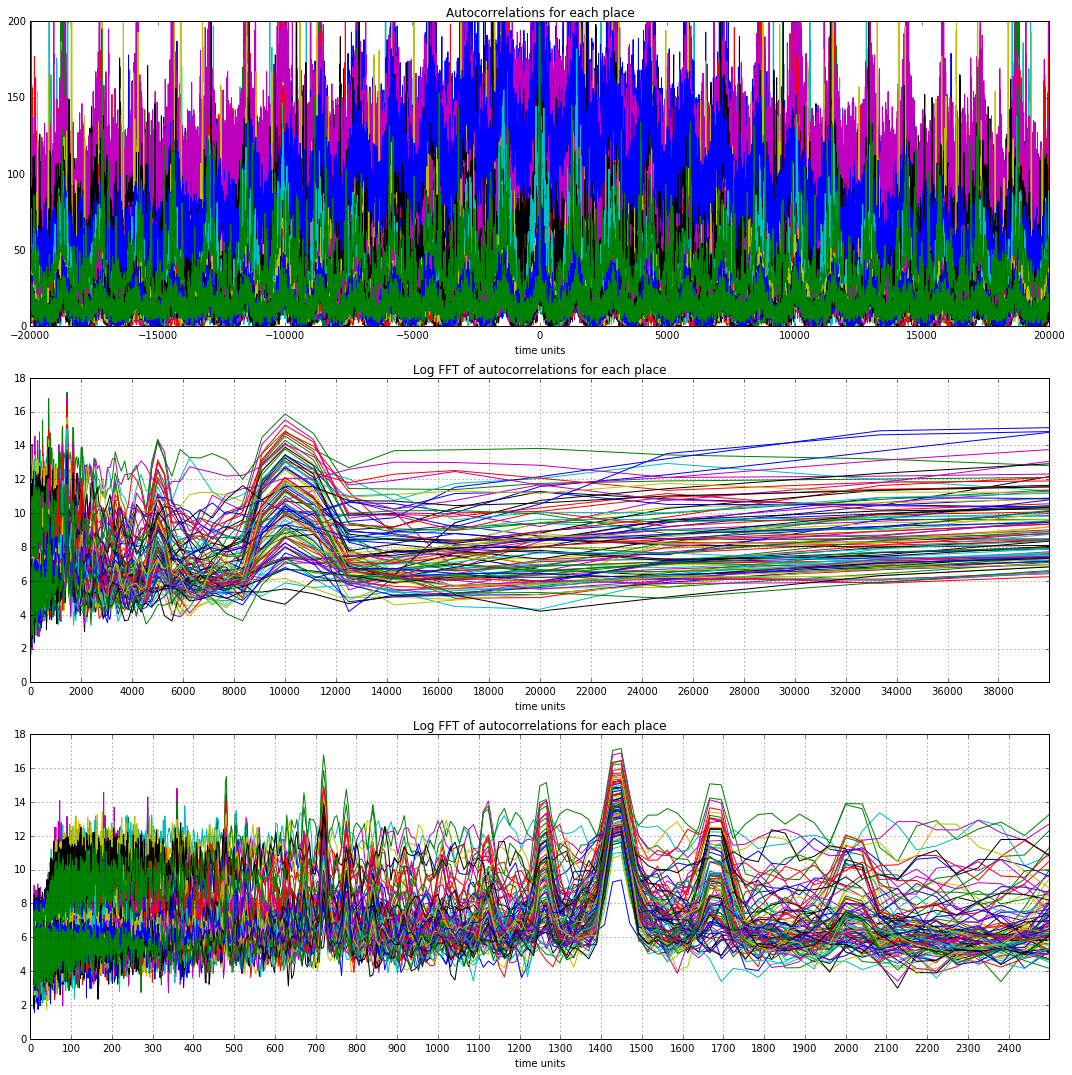

In [11]:
# Plot the autocorrelation and fft of autocorrelation
fig, axs = plt.subplots(3,1)

axs[0].plot(bin_edges[:-1], all_autocorrs)
axs[0].set_title('Autocorrelations for each place')
axs[0].set_xlabel('time units')
axs[0].set_xlim([-20000, 20000.0])
axs[0].set_ylim([0.0, 200.0])


f, psd = scipy.signal.welch(all_autocorrs, nperseg=25000, noverlap=20000, return_onesided=True, axis=0)

# Adjust the X axis to be in time points instead of 1/F
f /= 4.0 # Remember that there is one bin per 4.0 time units
f = 1.0/f # Go back to time points

# Plot the fft of the autocorrelation (The PSD of the timestamps)
axs[1].plot(f, np.log(psd))
axs[1].set_title('Log FFT of autocorrelations for each place')
axs[1].set_xlabel('time units')
axs[1].set_xlim([0.0, 40000.0])
axs[1].set_xticks(np.arange(0.0, 40000.0, 2000))
axs[1].grid(True)

# Plot the fft of the autocorrelation (zoomed)
axs[2].plot(f, np.log(psd))
axs[2].set_title('Log FFT of autocorrelations for each place')
axs[2].set_xlabel('time units')
axs[2].set_xlim([0.0, 2500.0])
axs[2].set_xticks(np.arange(0.0, 2500.0, 100))
axs[2].grid(True)

fig.tight_layout()
plt.show()

That's more like it!  
There is clearly a repeating pattern to this data. A wavelike pattern is seen in the autocorrelations and there are clear peaks in the PSD.  
The PSDs give some insight into the different time cycles occurring at each place.  
This result confirms that the time units are in minutes. The largest peak is at around 1440, which is the number of minutes in a day. There is another peak at around 10000, which is near the number of minutes in a week. Some other peaks can be seen too, at 5000, 1650, etc. Not sure what the significance of those are.  
The most interesting result is that each place kind of lives in its own little timezone. You'd think that the people living in this world would all behave according to a particular cycle, but that doesn't pan out in the global timestamp data.  